# Introduction of the project
- Students: Jessica RATOVONDRANTO and Kim Anh PHAM.
- Class: Advanced Topics in Finance, IRFA/MMMEF Spring 2023.


# Data Processing

The data that we are using are saved in 3 .csv files (sent along with this code) which tracks the performance of `SPXS`, `SPXL`, and `SPY` from January 3rd, 2017 to April 3rd, 2023 not including the weekend dates.

After a preliminary investigation of the 3 data bases, we saw that there is no missing data, and all the files have the same structure including trading volumes, opening, highest, lowest, and closing prices for each day. Below, we are selecting only the closing prices for our analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime as dt
import plotly.express as px

In [2]:
# Select only the closing prices of each ETF
df_price=pd.DataFrame()

for p in ['SPXS','SPXL','SPY']:
    path = p + '.csv'
    df = pd.read_csv(path, index_col='Date', parse_dates=True)
    df.drop(columns={'Open','High','Low','Adj Close','Volume'}, inplace=True)
    df.rename(columns={'Close':p}, inplace=True)
    
    df_price = pd.concat([df_price, df], axis=1)
    
df_price.head()

,SPXS,SPXL,SPY
Date,,,
2017-01-03,527.5,27.507500,225.240005
2017-01-04,519.0,27.995001,226.580002
2017-01-05,519.5,27.930000,226.399994
2017-01-06,514.0,28.245001,227.210007
2017-01-09,518.5,27.977501,226.460007


# Part 1 : Descriptive Analysis 


## 1.1 Historical Plot of prices

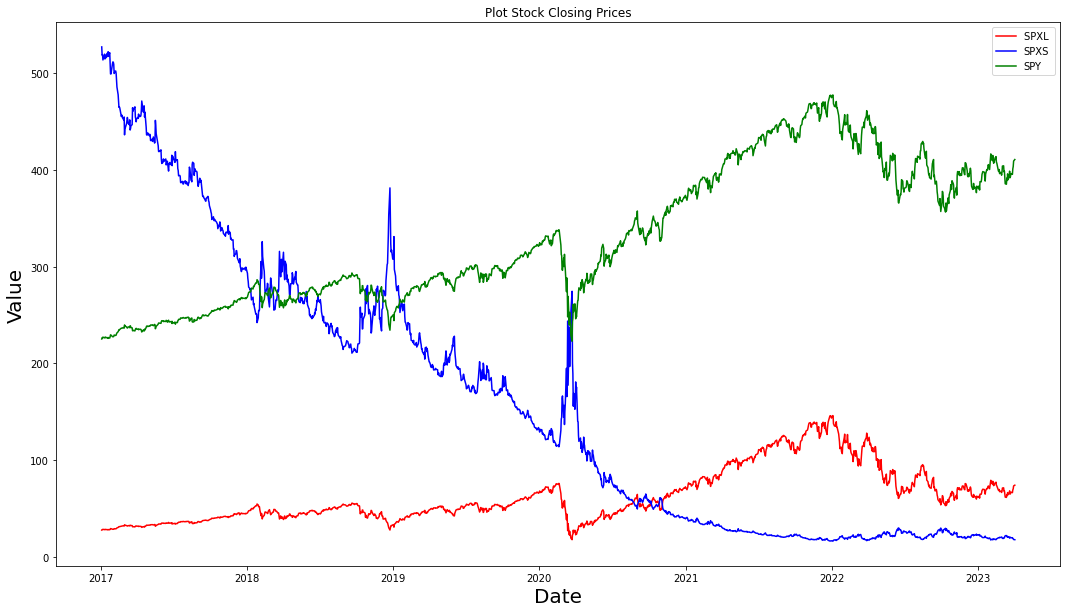

In [3]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(df_price['SPXL'], label = 'SPXL ',color = 'red')
ax.plot(df_price['SPXS'], label = 'SPXS',color = 'blue')
ax.plot(df_price['SPY'], label = 'SPY',color = 'green')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Value', fontsize = 20)

ax.set_title('Plot Stock Closing Prices')
ax.legend(fontsize=10)

plt.show()

In [ ]:
# Plot scaled data (divide each price series by its first value)
first_price = df_price.iloc[0,:].copy()

df_price_scaled = df_price.copy()
df_price_scaled = df_price_scaled/first_price

df_price_scaled.head()

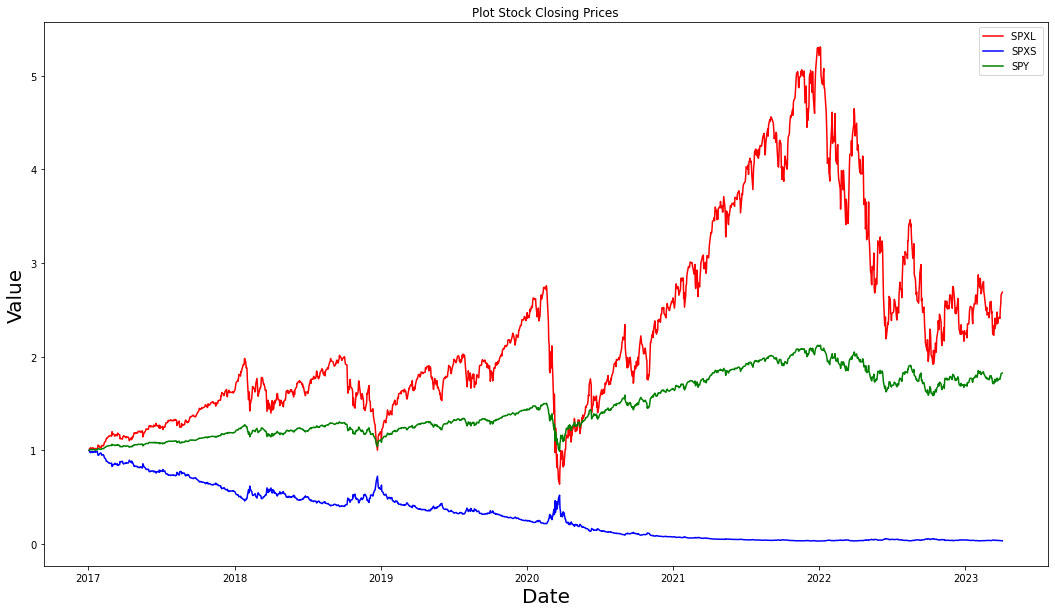

In [5]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(df_price_scaled['SPXL'], label = 'SPXL ',color = 'red')
ax.plot(df_price_scaled['SPXS'], label = 'SPXS',color = 'blue')
ax.plot(df_price_scaled['SPY'], label = 'SPY',color = 'green')
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Value', fontsize = 20)

ax.set_title('Plot Stock Closing Prices')
ax.legend(fontsize=10)

plt.show()

## 1.2 Descriptive Analysis


### 1.2.1 Plots of Prices and Daily Log Returns

In [6]:
# Extracting log daily return data from price data
daily_return = df_price.pct_change().dropna()
daily_return

,SPXS,SPXL,SPY
Date,,,
2017-01-04,-0.016114,0.017722,0.005949
2017-01-05,0.000963,-0.002322,-0.000794
2017-01-06,-0.010587,0.011278,0.003578
2017-01-09,0.008755,-0.009471,-0.003301
2017-01-10,0.002893,-0.000894,0.000000
...,...,...,...
2023-03-28,0.006667,-0.006452,-0.002245
2023-03-29,-0.041773,0.043642,0.014535
2023-03-30,-0.017544,0.016206,0.005855


In [7]:
# Extracting log daily return data from price data
daily_log_return = pd.DataFrame(index=df_price.index)

for i in df_price.columns:
    daily_log_return = pd.concat([daily_log_return,np.log(df_price[i]) - np.log(df_price[i].shift(1))],axis=1)

daily_log_return.dropna(inplace=True)
daily_log_return

,SPXS,SPXL,SPY
Date,,,
2017-01-04,-0.016245,0.017567,0.005932
2017-01-05,0.000963,-0.002325,-0.000795
2017-01-06,-0.010644,0.011215,0.003571
2017-01-09,0.008717,-0.009516,-0.003306
2017-01-10,0.002889,-0.000894,0.000000
...,...,...,...
2023-03-28,0.006644,-0.006473,-0.002247
2023-03-29,-0.042670,0.042717,0.014430
2023-03-30,-0.017700,0.016076,0.005838


<bound method Figure.show of <Figure size 1296x1080 with 3 Axes>>

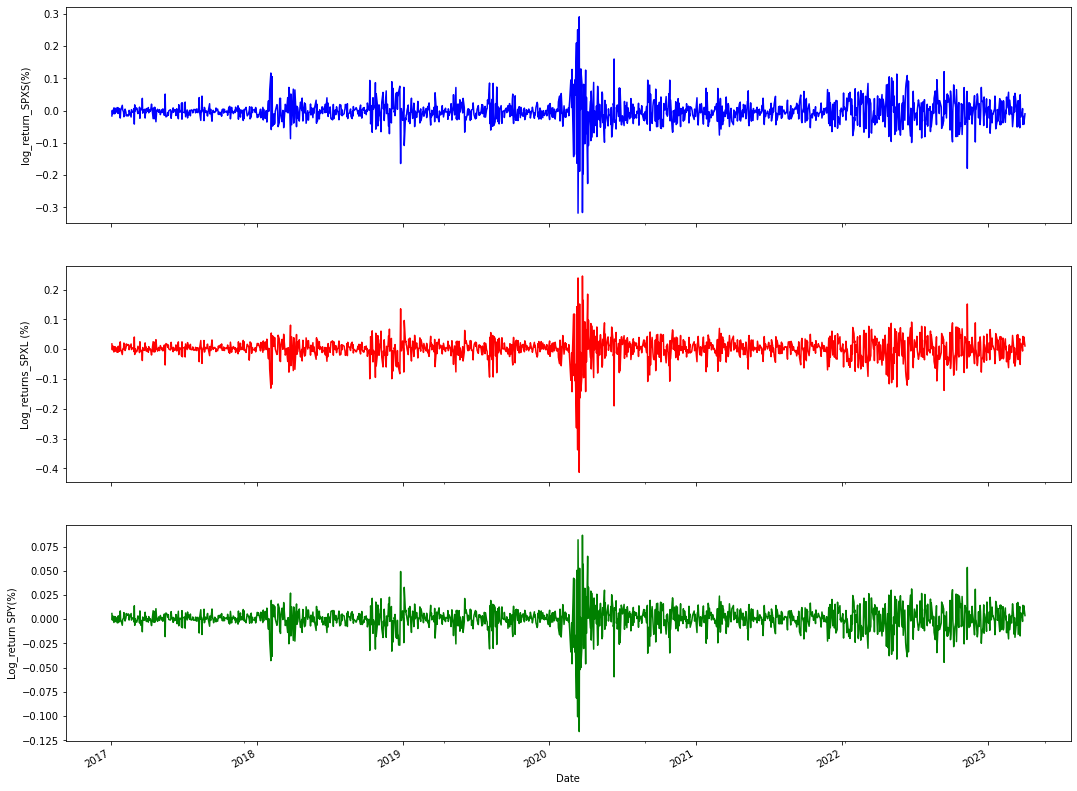

In [8]:
# Plotting log return
fig, ax = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
daily_log_return.SPXS.plot(ax=ax[0], color = 'b')
ax[0].set(ylabel='log_return_SPXS(%)')
daily_log_return.SPXL.plot(ax=ax[1], color = 'r')
ax[1].set(ylabel='Log_returns_SPXL (%)')
daily_log_return.SPY.plot(ax=ax[2], color='g')
ax[2].set(ylabel='Log_return SPY(%)', xlabel='Date')
fig.show

**Observations**: 

We observe a high level of fluctuation around March 2020, which was exactly the beginning of the Covid pandemic, and a period of higher fluctuation starting in 2022 until today, which corresponds to the current uncertainties including the war in Ukrain, energy crisis, and high inflation.

### 1.2.2 Statistics of Daily Log Retunrs 

We are calculating the following statistics (on an annualized basis) for the daily log returns: Mean, Standard Deviation, Skewness, Kurtosis, and Sharpe ratio. 

In [10]:
from scipy.stats import kurtosis

def Sharpe(series):
    ''' We assume that risk-free rate is 0. Hence, the Sharpe ratio is the mean divided by the standard deviation.'''
    mean = np.mean(series) # daily
    std = np.std(series) # annual
    return mean * np.sqrt(252) / std # annual

In [11]:
annual_stats = daily_log_return.resample('Y').agg(['mean', 'std', 'skew', kurtosis, Sharpe])
annual_stats = annual_stats.transpose()

for i in annual_stats.columns:
    annual_stats.rename(columns={i : i.date().year}, inplace=True)

annual_stats

Date               2017      2018      2019       2020      2021      2022  \
SPXS mean     -0.002263  0.000109 -0.003346  -0.004824 -0.003453  0.001229   
     std       0.012416  0.032079  0.023442   0.063800  0.024436  0.045669   
     skew      0.359736  0.131926  0.422341  -0.314236  0.238483 -0.207660   
     kurtosis  2.745910  3.564970  3.253973   7.403805  0.568056  0.469450   
     Sharpe   -2.898943  0.053984 -2.270398  -1.202658 -2.247429  0.428115   
SPXL mean      0.001909 -0.001188  0.002767   0.000353  0.002721 -0.003334   
     std       0.012600  0.032304  0.023666   0.065862  0.024457  0.045711   
     skew     -0.566091 -0.654437 -0.770659  -1.526272 -0.430815 -0.115128   
     kurtosis  2.959886  2.901607  3.371354  10.350316  0.764106  0.301149   
     Sharpe    2.409616 -0.584970  1.859998   0.085211  1.769361 -1.160086   
SPY  mean      0.000678 -0.000261  0.001004   0.000592  0.000950 -0.000863   
     std       0.004252  0.010822  0.007917   0.021271  0.008260  0.015298   
     skew     -0.439294 -0.484603 -0.644658  -0.888941 -0.375726 -0.001246   
     kurtosis  2.674265  3.113893  3.111492   7.581412  0.625903  0.302457   
     Sharpe    2.537170 -0.384052  2.016797   0.442804  1.828576 -0.897598   

Date               2023  
SPXS mean     -0.003811  
     std       0.031481  
     skew      0.050864  
     kurtosis -0.834524  
     Sharpe   -1.937225  
SPXL mean      0.002770  
     std       0.031097  
     skew     -0.195701  
     kurtosis -0.786340  
     Sharpe    1.425179  
SPY  mean      0.001142  
     std       0.010617  
     skew     -0.159246  
     kurtosis -0.832133  
     Sharpe    1.720701

In [12]:
annual_stats.loc[(['SPXS','SPXL','SPY'],'Sharpe'),:]

,Date,2017,2018,2019,2020,2021,2022,2023
SPXS,Sharpe,-2.898943,0.053984,-2.270398,-1.202658,-2.247429,0.428115,-1.937225
SPXL,Sharpe,2.409616,-0.584970,1.859998,0.085211,1.769361,-1.160086,1.425179
SPY,Sharpe,2.537170,-0.384052,2.016797,0.442804,1.828576,-0.897598,1.720701


**Observation** : Due to the positive delta of `SPXL`, its Sharpe ratio has the same sign as the Sharpe ratio of `SPY`. Vice versa, with a negative delta, `SPXS` has a Sharpe ratio with the opposite sign as that of `SPY`.

### 1.2.3 Correlation between the ETFs

Below we calculate the correlation between the ETFs across the entire data set (7 years).

In [13]:
correlation = daily_log_return.corr()
correlation

,SPXS,SPXL,SPY
SPXS,1.000000,-0.987802,-0.993321
SPXL,-0.987802,1.000000,0.996741
SPY,-0.993321,0.996741,1.000000


**Observations** : Since `SPXS` and `SPXL` are products following the constrant delta strategy with the underlying being `SPY`, we expect a high level of correlation, and they are in fact highly correlated.

# Part 2 : Power profiles and Gamma effects

## 2.1 Rolling 1-year return of `SPXL` and `SPXS` as a function of `SPY`

In [14]:
rolling_1yr = (df_price/df_price.shift(252)).dropna()
rolling_1yr

,SPXS,SPXL,SPY
Date,,,
2018-01-03,0.545782,1.671908,1.200808
2018-01-04,0.547977,1.663511,1.198738
2018-01-05,0.537055,1.698890,1.207686
2018-01-08,0.539689,1.690211,1.205581
2018-01-09,0.531533,1.718166,1.212311
...,...,...,...
2023-03-28,1.119156,0.548951,0.873887
2023-03-29,1.094241,0.560730,0.880327
2023-03-30,1.116616,0.549445,0.874662


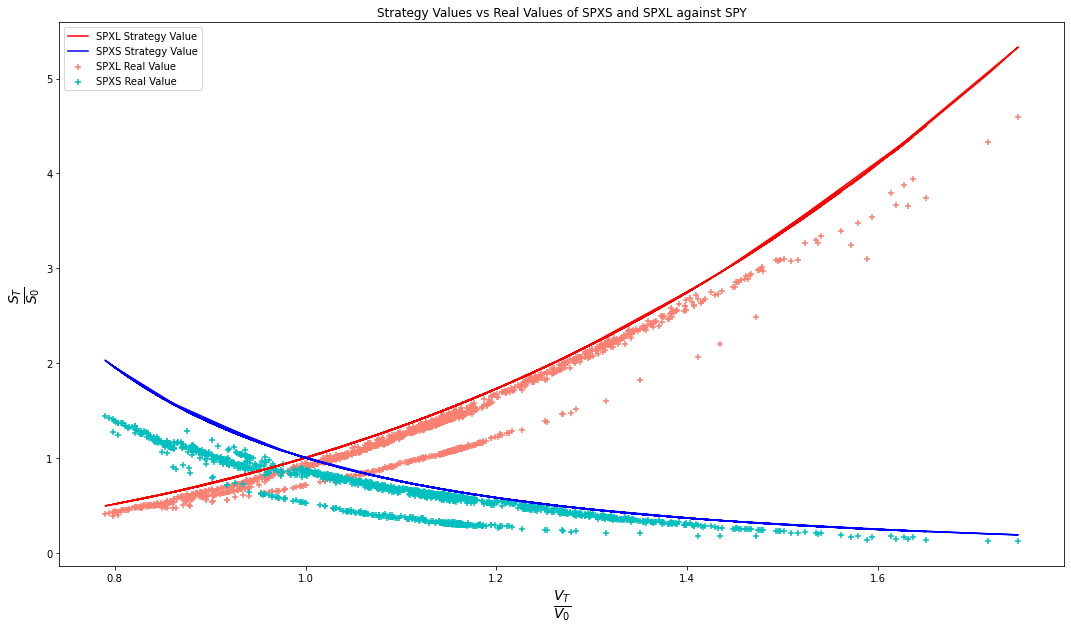

In [15]:
fig, ax = plt.subplots(figsize=(18,10))

# Real rolling-1-year values of SPXL and SPXS against SPY
ax.scatter(rolling_1yr['SPY'], rolling_1yr['SPXL'], label='SPXL Real Value',
       marker = '+', color = 'salmon')
ax.scatter(rolling_1yr['SPY'], rolling_1yr['SPXS'], label='SPXS Real Value',
       marker = '+', color = 'c')

# Strategic values (delta = 3 for SPXL and delta = -3 for SPXS)
ax.plot(rolling_1yr['SPY'], rolling_1yr['SPY']**3, label = 'SPXL Strategy Value',
       color = 'red')
ax.plot(rolling_1yr['SPY'], rolling_1yr['SPY']**(-3), label = 'SPXS Strategy Value',
       color = 'blue')

ax.set_xlabel(r'$\frac{V_T}{V_0}$', fontsize = 20)
ax.set_ylabel(r'$\frac{S_T}{S_0}$', fontsize = 20)

ax.set_title('Strategy Values vs Real Values of SPXS and SPXL against SPY')
ax.legend(fontsize=10)

plt.show()

**Observation**: 

We note that the real returns are always below the theoretical strategy values. With the financial training that we have, we know that such discrepancy between the observed and the expected values can be systematic, and such gap probably comes from the Gamma Effect, as illustrated below.

## 2.2 Gamma effect

We first calculate the realized variance of `SPY` for each period of 252 days using the daily log returns. Then, we compute the gamma effects based on these variances for `SPXS` and `SPXL` following the given formula with $l$ being the explicit delta in the ETF.

$\frac{V_T}{V_{T-252}} = (\frac{S_T}{S_{T-252}})^l \times \exp \left(-\frac{1}{2} \int_{T-252} ^{T} (l^2 - l) \sigma_{s}^2 ds \right)$

In [16]:
# Calculating realized variance of periods of 252 days (1 trading year)
daily_log_return['square_SPY'] = daily_log_return['SPY']*daily_log_return['SPY']
rolling_1yr['Accumul_Var'] = daily_log_return['square_SPY'].rolling(252).sum().dropna()

In [17]:
# Calculating the gamma effect 
def gamma_effect(l):
    return - 0.5*(l**2 - l)
rolling_1yr['trading_impact_SPXL'] = (rolling_1yr['SPY'] ** 3) * np.exp(gamma_effect(3)*rolling_1yr['Accumul_Var'])
rolling_1yr['trading_impact_SPXS'] = (rolling_1yr['SPY'] ** (-3)) * np.exp(gamma_effect(-3)*rolling_1yr['Accumul_Var'])

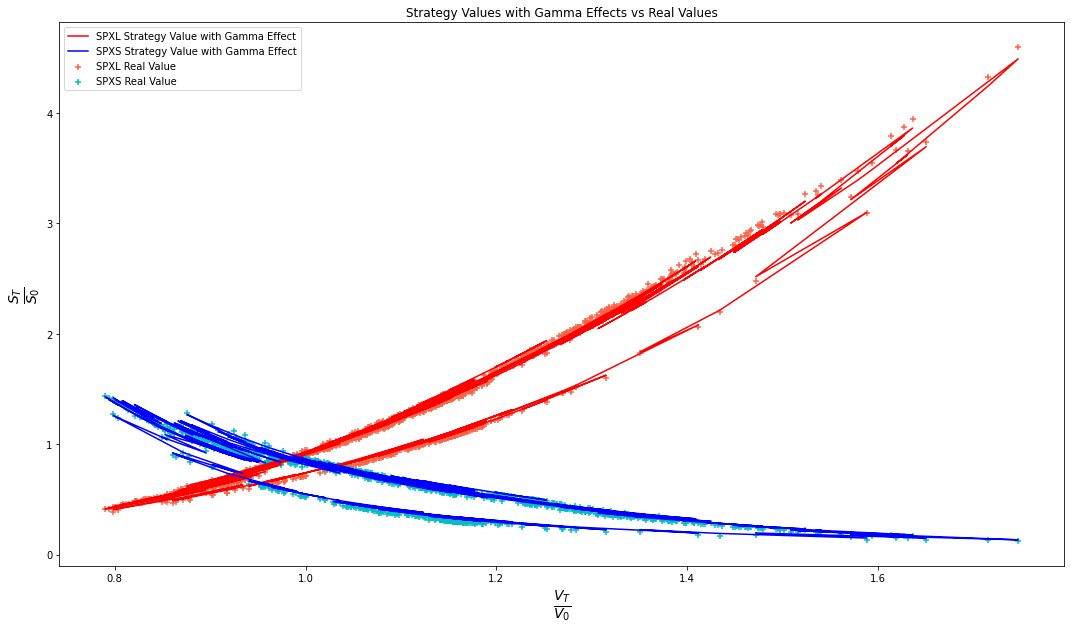

In [18]:
fig, ax = plt.subplots(figsize=(18,10))

# Strategic values with Gamma effects
ax.plot(rolling_1yr['SPY'], rolling_1yr['trading_impact_SPXL'], label = 'SPXL Strategy Value with Gamma Effect',
       color = 'red')
ax.plot(rolling_1yr['SPY'], rolling_1yr['trading_impact_SPXS'], label = 'SPXS Strategy Value with Gamma Effect',
       color = 'blue')

# Real values of SPXL and SPXS
ax.scatter(rolling_1yr['SPY'], rolling_1yr['SPXL'], label='SPXL Real Value',
       marker = '+', color = 'tomato')
ax.scatter(rolling_1yr['SPY'], rolling_1yr['SPXS'], label='SPXS Real Value',
       marker = '+', color = 'c')

ax.set_xlabel(r'$\frac{V_T}{V_0}$', fontsize = 20)
ax.set_ylabel(r'$\frac{S_T}{S_0}$', fontsize = 20)

ax.set_title('Strategy Values with Gamma Effects vs Real Values')
ax.legend()

plt.show()

**Observations** 

We observe that the theoretical values including the Gamma Effect show in the graph above fit much better with the real values of `SPXL` and `SPXS` than the theoretical values without the Gamma Effect (which is shown in the previous question). This means that to provide an "honest" depiction of the fund, we should always account for the trading impact in our calculation.

## 2.3 Commentary on the products

**What does this mean for investors ?**

This analysis has shown that investors should be aware of the trading impact of volatility which is implicit in these ETFs. 

To be more specific, investors should have a realistic expectation that their returns from the ETFs will lower than 3 times the return of the underlying index, and the difference between the ETFs' returns and the expected theoretical return (meaning, 3 times the return of the underlying index) is positively related to the volatility of the underlying index. In other words, the higher the volatility, the bigger the gap between the returns of the ETFs and 3 times the returns of the underlying index. In mathematical terms, such gap is the result of the $\exp \left(-\frac{1}{2} \int_{T-252} ^{T} (l^2 - l) \sigma_{s}^2 ds \right)$ component that we have seen above.

**Would you recommend these products ?**

We would not expect a perfect product which always guarantee the greatest results without any drawbacks for the customers (which should be impossible due to no-arbitrage). Hence, we think that these ETFs **do** have the potential to be beneficial to the investors. However, as investors take on the risk of the convexity (the Gamma Effect in this case), we would advice our customers to buy additional products to hedge against volatility complement these ETFs. 

# Part 3 : Analysis on Providers' Information page

### 3.1 Did they explain appropriately the nature of the product for a novice investor ? 

Overall, we believe that the providers have made an effort to explain the trading impact in layman's terms. Specifically, in the first 3 questions and the second-to-last question on the FAQ page, they have repetitively said how the observed returns of the funds will not be as high as exactly 3 times the returns of the underlying index and they simply explained that such phenomenon is due to the volatility. 

However, in our opinion, they have only described the phenomenon without clearly explaining the mechanism behind it. 

### 3.2 Would you suggest any modification to their FAQ page ?

We would suggest a small section dedicating to explaining the mechanism behind the gap between the ETFs' returns and 3 times the returns of the underlying index. For a layman investor, with the objective of being transparent, we can simply say that the volatility of the underlying index negatively impacts the performance of the ETFs, so the more the underlying index fluctuates, the worse the funds will perform.